# Object Detection Fine Tune Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/untrall/cs8803asi/blob/main/Object_detection_Fine_Tune.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/untrall/cs8803asi/blob/main/Object_detection_Fine_Tune.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/untrall/cs8803asi/main/Object_detection_Fine_Tune.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [ ]:
!pip install evadb

In [5]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File ‘00-start-eva-server.ipynb’ already there; not retrieving.

nohup eva_server >> eva.log 2>&1 &
('Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth\n', "/usr/local/lib/python3.9/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour\n", '  warnings.warn(\n')
('Downloading: "https://github.com/ultralytics/yolov5/zipball/mast

### Download the Videos and Required Scripts

In [ ]:
# Getting the video files
!wget -nc https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4?raw=1 -O ua_detrac.mp4
# Getting the fine-tuned Yolo object detector
!wget -nc https://raw.githubusercontent.com/untrall/cs8803asi/main/yolo_fine_tune.py
# Getting the fine-tuned weights for YoloV5
!wget -nc https://raw.githubusercontent.com/untrall/cs8803asi/main/model.pt

### Load the surveillance videos for analysis

##### We use regular expression to load all the videos into the table

In [8]:
cursor.execute('DROP TABLE ObjectDetectionVideos')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD VIDEO "ua_detrac.mp4" INTO ObjectDetectionVideos;')
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.FAIL
@batch: 
 None
@error: Table: ObjectDetectionVideos does not exist
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded VIDEO: 1
@query_time: 0.16590498300001855


### Visualize Video

In [18]:
from IPython.display import Video
Video("ua_detrac.mp4", embed=True)

### Register YOLO Object Detector with fine-tuned weights as a User-Defined Function (UDF) in EVA 

In [10]:
## custom fine-tuned weights are already loaded in yolo_fine_tune.py
cursor.execute("""CREATE UDF IF NOT EXISTS YoloV5_Fine_Tune
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
                scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'yolo_fine_tune.py';
      """)
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                                           0
0  UDF YoloV5_Fine_Tune successfully added to the database.
@query_time: 8.71307866199993


### Run Object Detector with fine-tuned weights on the video

In [11]:
cursor.execute("""SELECT id, YoloV5_Fine_Tune(data)
                  FROM ObjectDetectionVideos 
                  WHERE id < 20""")
response_1 = cursor.fetch_all()
response_1.as_df()

,objectdetectionvideos.id,yolov5_fine_tune.labels,yolov5_fine_tune.bboxes,yolov5_fine_tune.scores
0,0,"[car, car, car, car, car, car, car, car, car, ...","0 [344.8067932128906, 161.20376586914062, ...","[0.9163849353790283, 0.9108870029449463, 0.901..."
1,1,"[car, car, car, car, car, car, car, car, car, ...","0 [344.0391845703125, 159.93603515625, 383...","[0.9181259274482727, 0.9156777858734131, 0.900..."
2,2,"[car, car, car, car, car, car, car, car, car, ...","0 [343.340087890625, 158.72604370117188, 3...","[0.9107299447059631, 0.9058220386505127, 0.901..."
3,3,"[car, car, car, car, car, car, car, car, car, ...","0 [225.69769287109375, 276.7891845703125, ...","[0.9258053302764893, 0.9152998924255371, 0.904..."
4,4,"[car, car, car, car, car, car, car, car, car, ...","0 [226.0989990234375, 275.2127685546875, 3...","[0.9318802356719971, 0.9098677635192871, 0.908..."
5,5,"[car, car, car, car, car, car, car, car, car, ...","0 [227.21322631835938, 272.52886962890625,...","[0.9353176355361938, 0.9241136908531189, 0.907..."
6,6,"[car, car, car, car, car, car, car, car, car, ...","0 [855.593505859375, 283.8282165527344, 96...","[0.9086148142814636, 0.9067200422286987, 0.896..."
7,7,"[car, car, car, car, car, car, car, car, car, ...","0 [229.84664916992188, 272.3326721191406, ...","[0.9061142206192017, 0.8994450569152832, 0.891..."
8,8,"[car, car, car, car, car, car, car, car, car, ...","0 [229.79049682617188, 270.18408203125, 30...","[0.904857337474823, 0.8945248126983643, 0.8919..."
9,9,"[car, car, car, car, car, car, car, car, car, ...","0 [229.74533081054688, 268.3025817871094, ...","[0.919360876083374, 0.8978973627090454, 0.8927..."


### Visualizing output of the Object Detector on the video

In [12]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        df = detections
        df = df[['yolov5_fine_tune.bboxes', 'yolov5_fine_tune.labels']][df.index == frame_id]
        if df.size:
            dfLst = df.values.tolist()
            for bbox, label in zip(dfLst[0][0], dfLst[0][1]):
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                # object bbox
                frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
                # object label
                cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness) 
                # frame label
                cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness) 
            video.write(frame)

            # Stop after twenty frames (id < 20 in previous query)
            if frame_id == 20:
                break

            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(frame)
                plt.show()

        
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

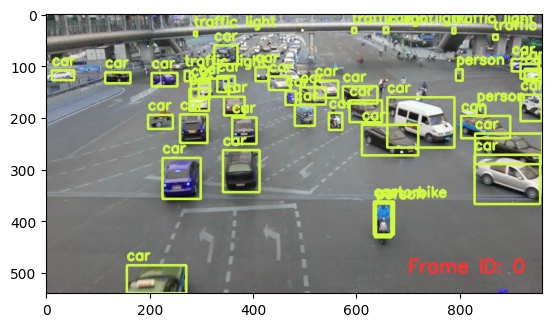

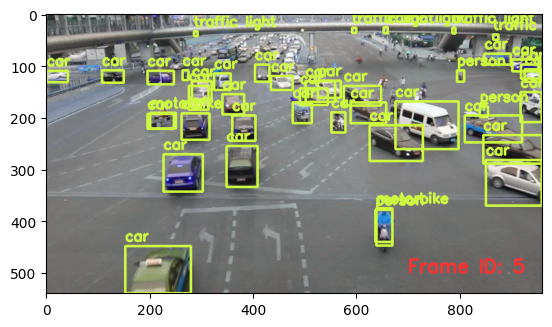

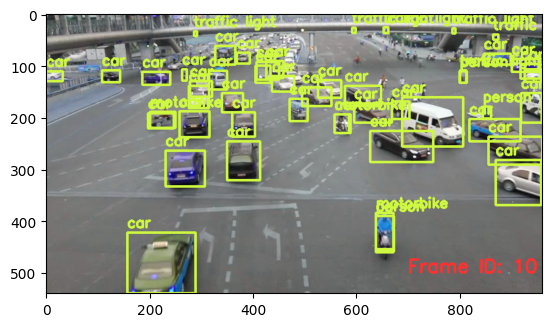

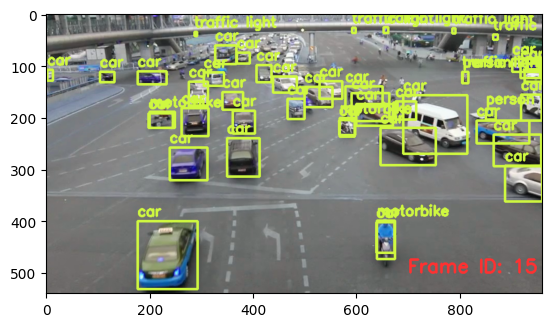

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\r\xfd\xbemdat\x00\x…

In [22]:
from ipywidgets import Video, Image
input_path = 'ua_detrac.mp4'
output_path = 'video.mp4'

dataframe = response_1.as_df()
annotate_video(dataframe, input_path, output_path)
Video.from_file(output_path)

### Dropping an User-Defined Function (UDF)

In [23]:
cursor.execute("DROP UDF YoloV5;")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                  0
0  UDF YoloV5 successfully dropped
@query_time: 0.027524014000050556
